In [1]:
import query_helper
import pandas as pd 
import charlie_functions
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
query_helper.set_database_name('MLB_Stats')

In [3]:
games_teams = query_helper.query_to_df("""select G.gameid, G.home_team, t.team_name as away_team, G.game_date, G.status from 
(select g.gameid, g.game_date, g.status, t.team_name as home_team, g.away_id
from MLB_Stats.games g 
inner join MLB_Stats.teams t on t.team_id=g.home_id) G
inner join MLB_Stats.teams t on t.team_id=G.away_id;""")

In [4]:
#data.groupby(data.date.dt.year)
games_per_year = games_teams.groupby(games_teams.game_date.dt.year).count()['gameid']

In [5]:
games_per_year

game_date
2009    2394
2010    2408
2011    2380
2012    2409
2013    2392
2014    2390
2015    2389
2016    2404
2017    2392
2018    2379
2019    2388
Name: gameid, dtype: int64

In [6]:
runs_games = query_helper.query_to_df("""SELECT A.gameid, A.total_runs, t.league FROM 
(SELECT g.gameid, i.home_team_runs + i.away_team_runs as total_runs, g.home_id
from games g
inner join game_info i on i.gameid=g.gameid) A
inner join teams t on t.team_id=A.home_id;""")

In [7]:
NL = runs_games[runs_games['league']=='NL']
AL = runs_games[runs_games['league']=='AL']

In [8]:
contigency = pd.crosstab(runs_games['total_runs'],runs_games['league'])
contigency

league,AL,NL
total_runs,,
1,215,298
2,242,280
3,767,916
4,643,707
5,1225,1380
6,966,954
7,1459,1454
8,1016,1034
9,1367,1386


In [9]:
NL_runs = NL['total_runs']
AL_runs = AL['total_runs']

In [10]:
#two-sided, two-sample T-Test
#Null Hyp: means are equal
#Alt Hyp: means are not equal
stats.ttest_ind(NL_runs,AL_runs,equal_var=False)

Ttest_indResult(statistic=-7.307962173390232, pvalue=2.7894450131300715e-13)

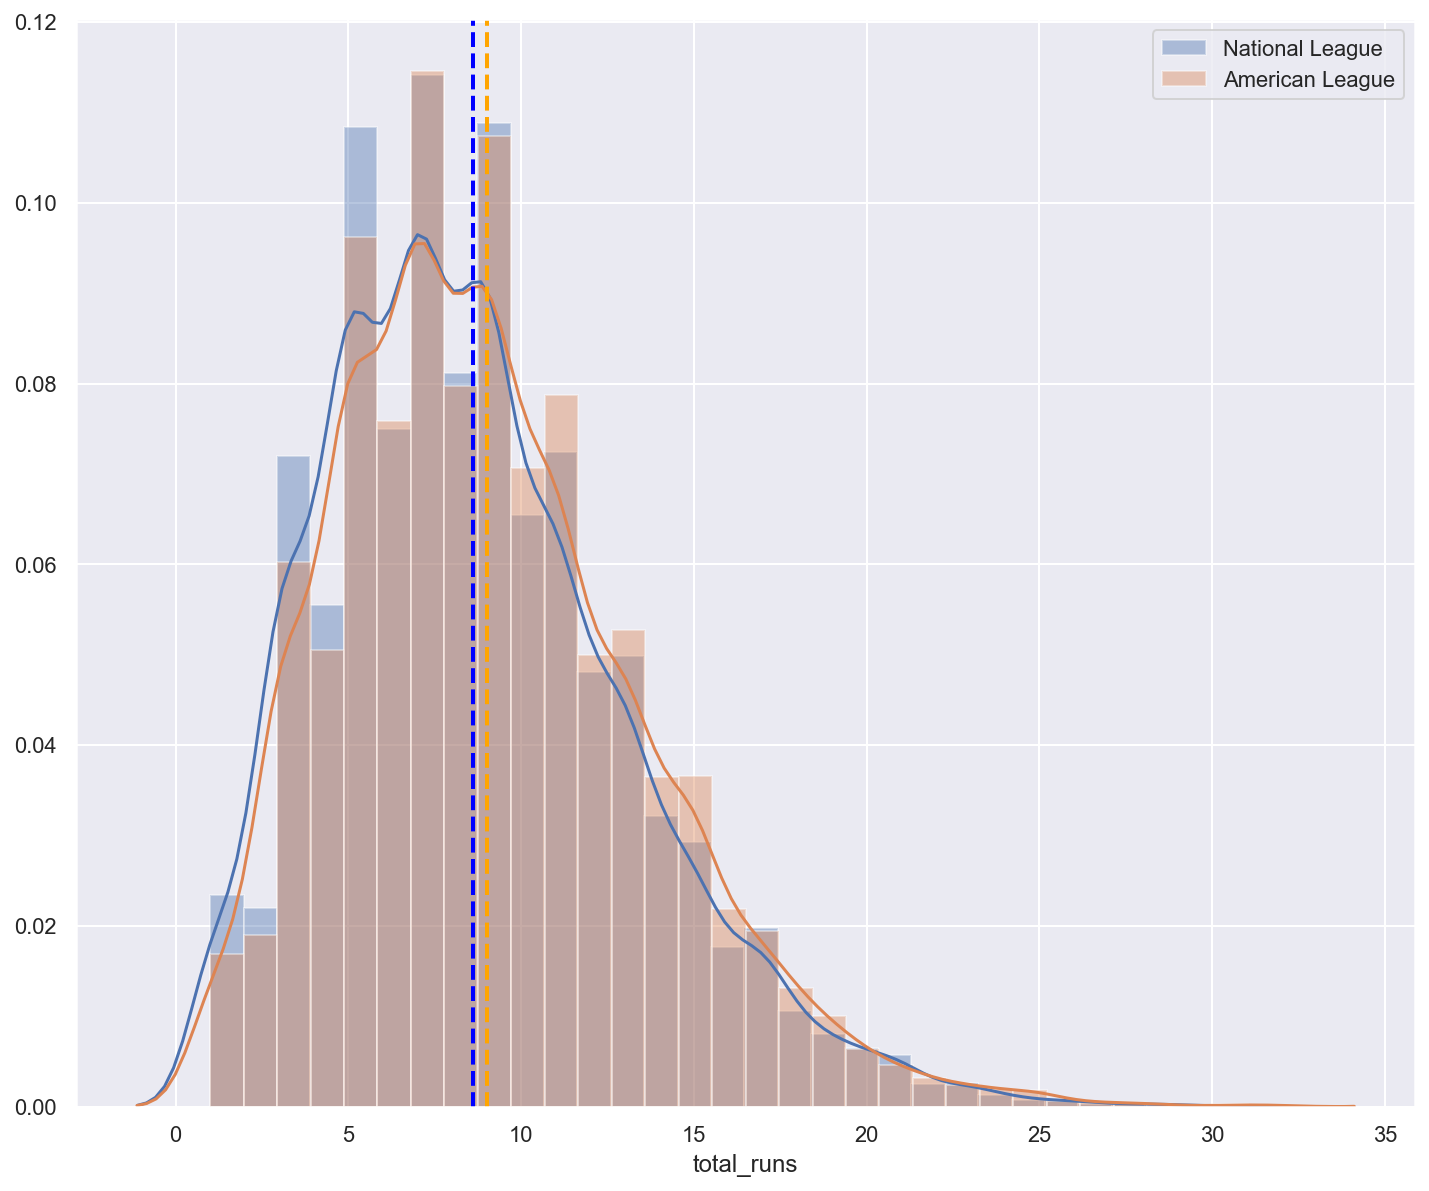

In [11]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(NL_runs,bins=NL_runs.max(),label='National League') # Blue distribution
sns.distplot(AL_runs,bins=AL_runs.max(),label='American League') # Green distribution
#plt.xticks(ticks=range(32))
plt.legend()
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=2)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=2)

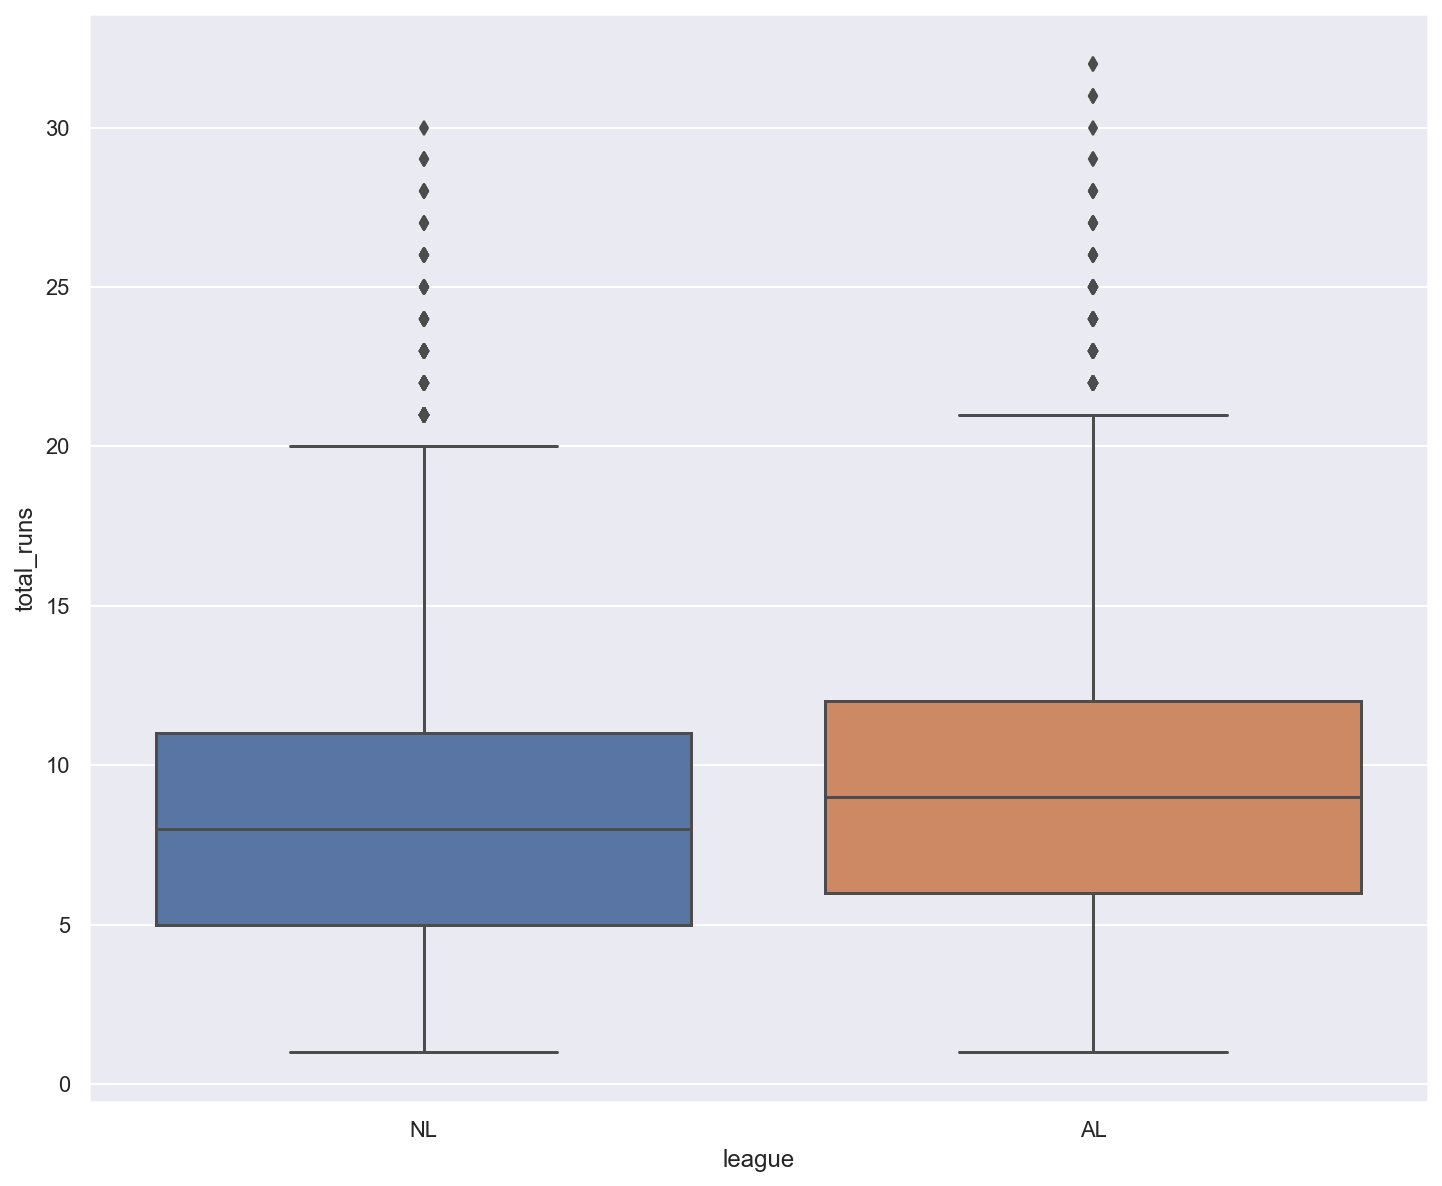

In [12]:
sns.boxplot(x=runs_games['league'],y=runs_games['total_runs'],orient='v')
#sns.boxplot(AL_runs,orient='v')

In [14]:
NL_samples = [np.random.choice(NL_runs, replace=False, size=30) for i in range(len(NL_runs/30))]
AL_samples = [np.random.choice(AL_runs, replace=False, size=30) for i in range(len(AL_runs/30))]

In [15]:
NL_sampleMeans = [np.mean(i) for i in NL_samples]
AL_sampleMeans = [np.mean(i) for i in AL_samples]

Text(0.5, 0, 'Mean Runs Scored per Game')

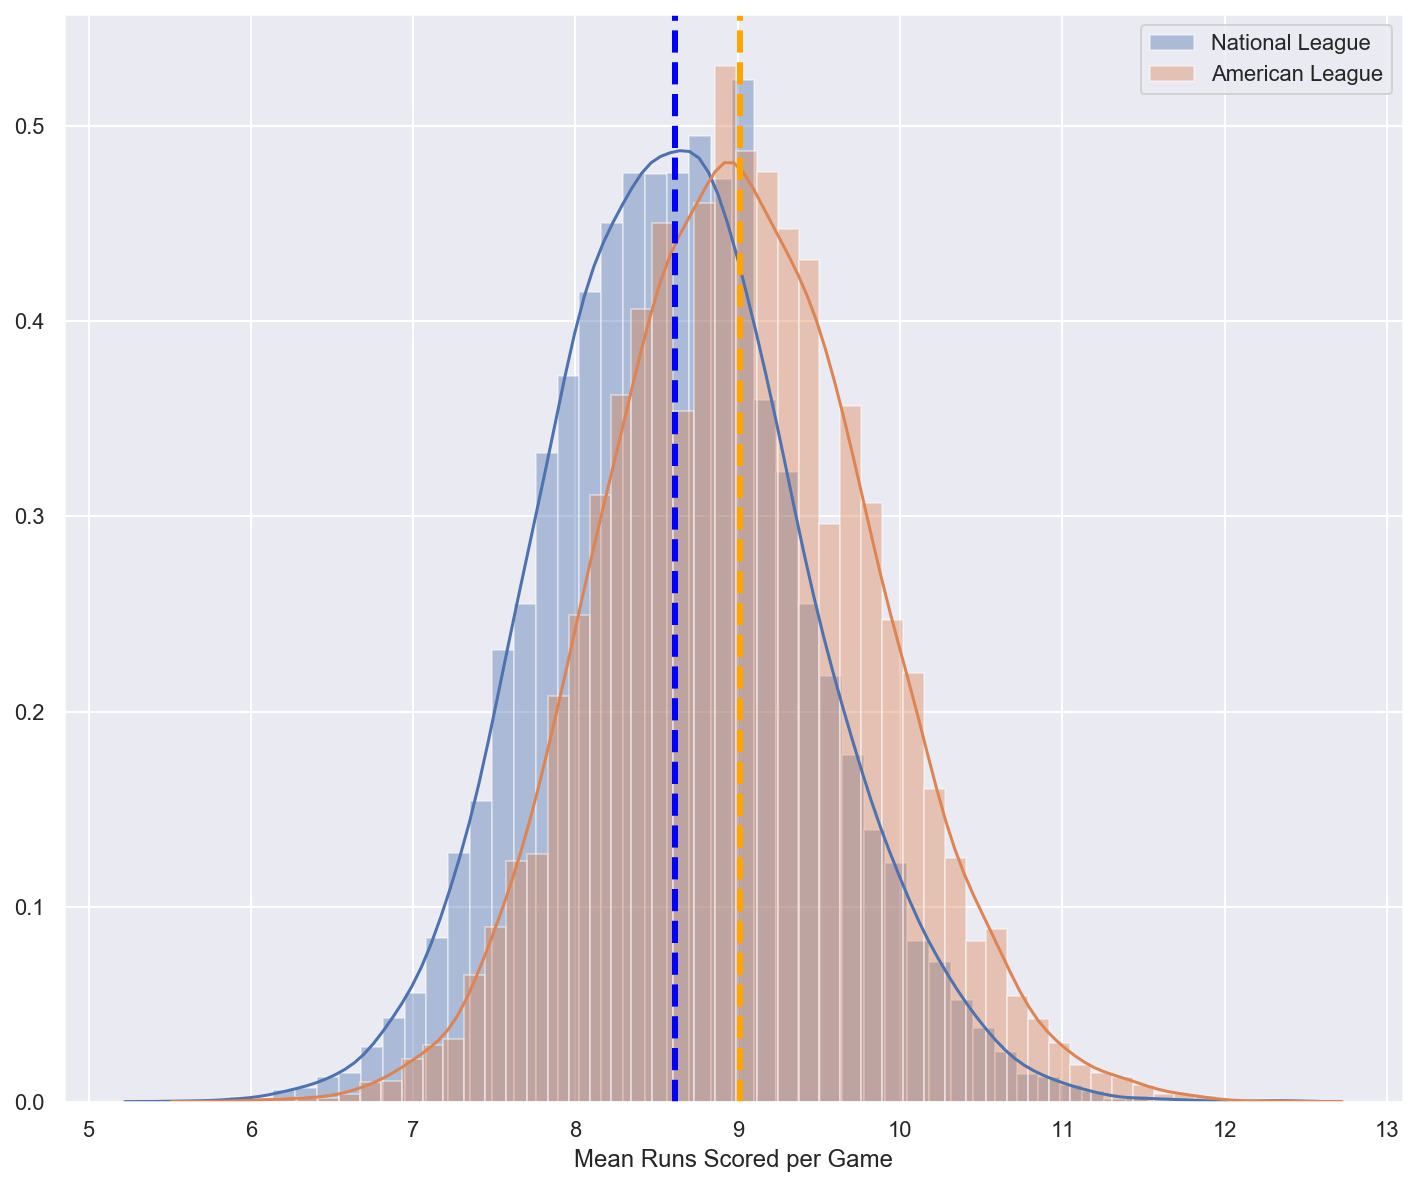

In [23]:
sns.distplot(NL_sampleMeans,label='National League')
sns.distplot(AL_sampleMeans,label='American League')
plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=3)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=3)
plt.legend()
plt.xlabel('Mean Runs Scored per Game')

In [29]:
runs_by_venue = query_helper.query_to_df("""select 
B.run_total, B.venue_name 
FROM
(select i.gameid, i.away_team_runs+i.home_team_runs as run_total, v.`name` as venue_name 
from MLB_Stats.game_info i 
inner join MLB_Stats.venues v 
on i.venue_id=v.venue_id) B;""")


In [32]:
runs_by_venue.set_index('venue_name')

,run_total
venue_name,
Citizens Bank Park,5
Minute Maid Park,6
Rangers Ballpark in Arlington,10
Chase Field,17
Rogers Centre,17
...,...
Miller Park,11
Miller Park,11
Miller Park,7
